# SNA Measures for Followers and Following data

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import json
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

## Egonets

These are ego-centric networks. Here the ego in the network is one of our users of interest (those that will appear in the rec sys).

There is an inward directed edge from each follower to the ego, an outward directed edge from the ego to each followed, and we additionaly store the follower count of the ego to indicate their popularity/importance. (SEE: workshop 6 from Jeff).


In [3]:
# Open the followers file and read in all followers, constructing a list of grpahs
from pathlib import Path

egos = {}
for child in Path('./data/egonets/followers').iterdir():
    if child.is_file():
        egoname = child.name.split('.json')[0]
        followers = json.loads(child.read_text())['nodes']
        egos[egoname] = {'followers': followers, 'following': []}
    
for child in Path('./data/egonets/following').iterdir():
    if child.is_file():
        egoname = child.name.split('.json')[0]
        following = json.loads(child.read_text())['nodes']
        egos[egoname]['following'] = following


In [5]:
# Construct egonets for each ego
ego_graphs = {}
for ego in egos:
    followers = egos[ego]['followers']
    following = egos[ego]['following']
    followers_count = len(followers)
    following_count = len(following)
    
    egonet = nx.DiGraph()
    # Add the ego with their attributes
    egonet.add_node(ego, is_ego=True, followers_count=followers_count, following_count=following_count)
    
    # Add followers nodes
    for f in followers:
        egonet.add_node(f['login'])
        egonet.add_edge(f['login'], ego)
        
    for f in following:
        egonet.add_node(f['login'])
        egonet.add_edge(ego, f['login'])
    
    ego_graphs[ego] = egonet
 

In [26]:
# Analyse the egonets
ego_df = pd.DataFrame({
    'ego': [], 
    'in_deg': [], 
    'out_deg': [],
    'deg_centrality': [],
    'eigenvector_centrality': [],
    'katz_centrality': [],
    'reciprocity': [],
    
})

for ego in egos:
    g = ego_graphs[ego]
    in_deg = g.in_degree(ego)
    out_deg = g.out_degree(ego)
    deg_cent = nx.degree_centrality(g)[ego]
    try:
        eigenvector_cent = nx.eigenvector_centrality(g)[ego]
    except:
        eigenvector_cent = np.nan
    katz_cent = nx.katz_centrality(g)[ego]
    try:
        rec = nx.reciprocity(g)
    except:
        rec = np.nan
    ego_df.loc[len(ego_df)] = [ego, in_deg, out_deg, deg_cent, eigenvector_cent, katz_cent, rec]

print('Head of ego nets')
display(ego_df.head())

Head of ego nets


,ego,in_deg,out_deg,deg_centrality,eigenvector_centrality,katz_centrality,reciprocity
0,Accordingtomark,25,25,1.000000,0.004394,0.384610,0.000000
1,moersoy,25,25,1.315789,0.569497,0.451323,0.480000
2,codekip,2,9,1.100000,0.316231,0.326490,0.181818
3,FlyLeon,0,1,1.000000,NaN,0.672673,0.000000
4,willmav5000,18,13,1.033333,0.267268,0.415239,0.064516


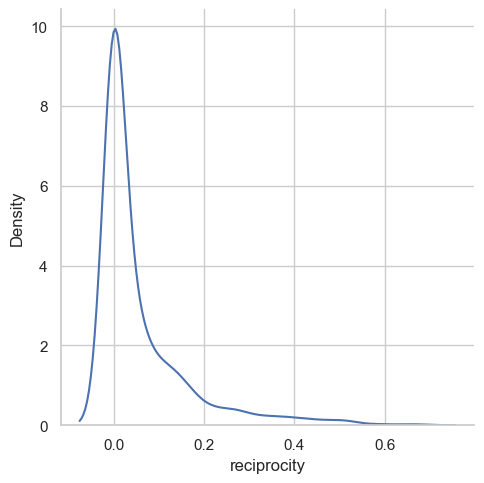

In [36]:
# sns.histplot(data=ego_df['deg_centrality'])
# sns.despine()
rec = list(ego_df['reciprocity'])
rec = [np.round(r, 2) for r in rec]
sns.displot(data=ego_df, x='reciprocity', kind='kde')

# sns.histplot(rec)

In [173]:
print('Descriptive statistics')
display(ego_df.describe())

max_in_deg = ego_df[ego_df['in_deg'] == 25]
max_out_deg = ego_df[ego_df['out_deg'] == 25]
max_in_and_out_deg = ego_df[(ego_df['in_deg'] == 25) & (ego_df['out_deg'] == 25)]

min_in_deg = ego_df[ego_df['in_deg'] == 0]
min_out_deg = ego_df[ego_df['out_deg'] == 0]
min_in_and_out_deg = ego_df[(ego_df['in_deg'] == 0) & (ego_df['out_deg'] == 0)]

print(f'Number of nodes of maximal in-degree: {len(max_in_deg)}')
print(f'Number of nodes of maximal out-degree: {len(max_out_deg)}')
print(f'Number of nodes of maximal in-degree and out-degree: {len(max_in_and_out_deg)}')
print(f'Number of nodes of minimal in-degree: {len(min_in_deg)}')
print(f'Number of nodes of minimal out-degree: {len(min_out_deg)}')
print(f'Number of nodes of minimal in-degree and out-degree: {len(min_in_and_out_deg)}')

Descriptive statistics


,in_deg,out_deg,deg_centrality,eigenvector_centrality,katz_centrality,reciprocity
count,1162.000000,1162.000000,1162.000000,748.000000,1162.000000,1157.000000
mean,16.510327,18.231497,1.032861,0.205737,0.390599,0.057280
std,8.969293,9.068251,0.065525,0.193666,0.090499,0.104814
min,0.000000,0.000000,1.000000,0.002247,0.178885,0.000000
25%,8.000000,9.000000,1.000000,0.004394,0.349170,0.000000
50%,19.500000,25.000000,1.000000,0.196127,0.384610,0.000000
75%,25.000000,25.000000,1.041667,0.327330,0.411711,0.080000
max,25.000000,25.000000,1.515152,1.000000,1.000000,0.680000


Number of nodes of maximal in-degree: 499
Number of nodes of maximal out-degree: 661
Number of nodes of maximal in-degree and out-degree: 400
Number of nodes of minimal in-degree: 16
Number of nodes of minimal out-degree: 46
Number of nodes of minimal in-degree and out-degree: 5


In [187]:
display(ego_df.sort_values(by='katz_centrality', ascending=False).drop(columns=['eigenvector_centrality']).iloc[5:].head(10))
display(ego_df.sort_values(by='reciprocity', ascending=False).drop(columns=['eigenvector_centrality']).head(10))


,ego,in_deg,out_deg,deg_centrality,katz_centrality,reciprocity
707,kk100500,1,0,1.0,0.739940,0.0
350,whwqs,1,0,1.0,0.739940,0.0
200,wuzhiping,1,0,1.0,0.739940,0.0
1159,Frankly-BmAn,1,0,1.0,0.739940,0.0
305,KyleCharters,1,0,1.0,0.739940,0.0
120,pretcat,1,0,1.0,0.739940,0.0
774,lxb1628,0,1,1.0,0.672673,0.0
701,interloper42,0,1,1.0,0.672673,0.0
3,FlyLeon,0,1,1.0,0.672673,0.0
597,sleepsterz,0,1,1.0,0.672673,0.0


,ego,in_deg,out_deg,deg_centrality,katz_centrality,reciprocity
529,liudhzhyym,25,25,1.515152,0.482719,0.680000
905,rantingmong,16,18,1.478261,0.442490,0.647059
329,uzuky,13,17,1.428571,0.415135,0.600000
604,mostlyfine,4,3,1.400000,0.506370,0.571429
848,osigge,11,4,1.363636,0.519560,0.533333
732,cliffpyles,15,15,1.363636,0.437130,0.533333
332,sh19910711,25,25,1.351351,0.457437,0.520000
695,BEN00262,14,21,1.346154,0.391017,0.514286
799,eloaders,14,25,1.344828,0.372597,0.512821
681,txl263,2,6,1.333333,0.406838,0.500000


HIGH IN-DEGREE


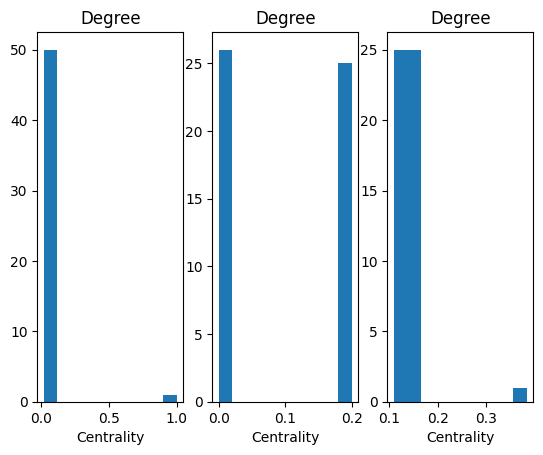

HIGH OUT-DEGREE


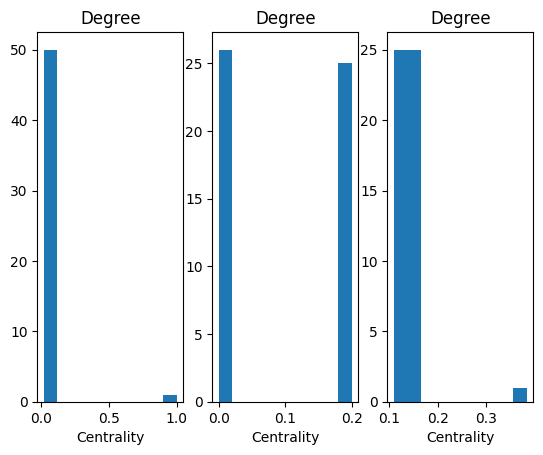

HIGH IN-DEGREE AND OUT-DEGREE


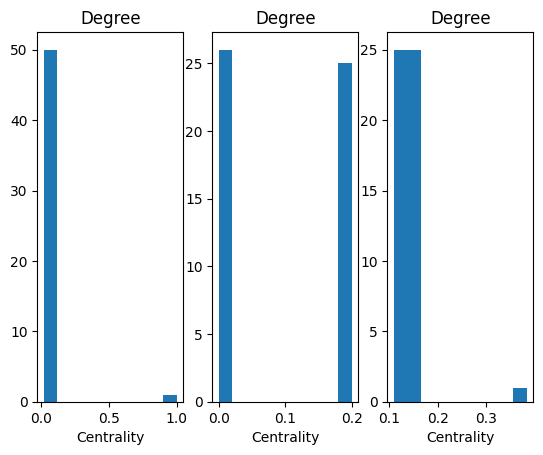

MIN IN-DEGREE


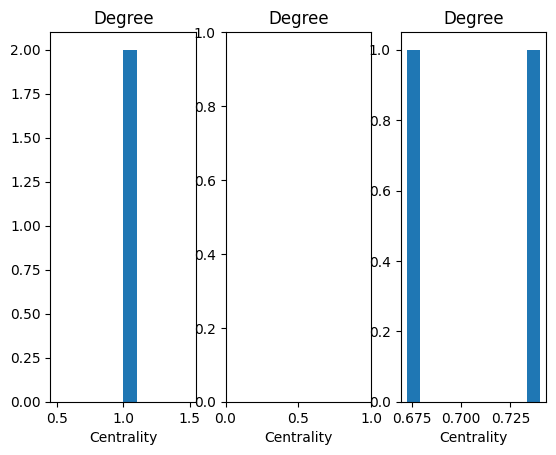

MIN OUT-DEGREE


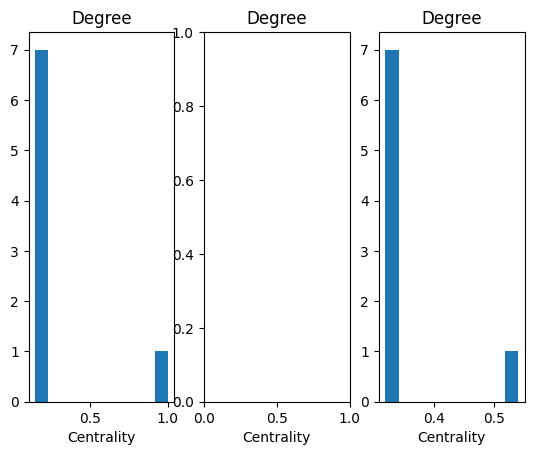

MIN IN-DEGREE AND OUT-DEGREE


Text(0.5, 0, 'Centrality')

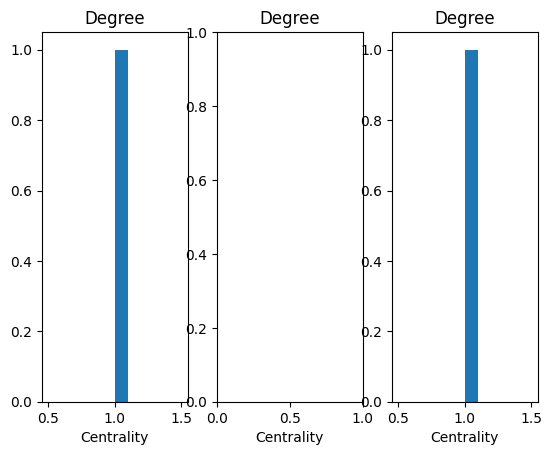

In [128]:
# Display degree, eigenvector, and katz centrality for a high in_deg, high out_deg, low in_deg, and low out_deg
# TODO: place repeated code in loop
print('HIGH IN-DEGREE')
plt.subplot(1, 3, 1)
plt.hist(list(nx.degree_centrality(ego_graphs[max_in_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 2)
plt.hist(list(nx.eigenvector_centrality(ego_graphs[max_in_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 3)
plt.hist(list(nx.katz_centrality(ego_graphs[max_in_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.show()

print('HIGH OUT-DEGREE')
plt.subplot(1, 3, 1)
plt.hist(list(nx.degree_centrality(ego_graphs[max_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 2)
plt.hist(list(nx.eigenvector_centrality(ego_graphs[max_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 3)
plt.hist(list(nx.katz_centrality(ego_graphs[max_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.show()

print('HIGH IN-DEGREE AND OUT-DEGREE')
plt.subplot(1, 3, 1)
plt.hist(list(nx.degree_centrality(ego_graphs[max_in_and_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 2)
plt.hist(list(nx.eigenvector_centrality(ego_graphs[max_in_and_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 3)
plt.hist(list(nx.katz_centrality(ego_graphs[max_in_and_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.show()

plt.show()
print('MIN IN-DEGREE')
plt.subplot(1, 3, 1)
plt.hist(list(nx.degree_centrality(ego_graphs[min_in_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 2)
# plt.hist(list(nx.eigenvector_centrality(ego_graphs[min_in_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 3)
plt.hist(list(nx.katz_centrality(ego_graphs[min_in_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.show()

print('MIN OUT-DEGREE')
plt.subplot(1, 3, 1)
plt.hist(list(nx.degree_centrality(ego_graphs[min_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 2)
# plt.hist(list(nx.eigenvector_centrality(ego_graphs[min_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 3)
plt.hist(list(nx.katz_centrality(ego_graphs[min_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.show()

print('MIN IN-DEGREE AND OUT-DEGREE')
plt.subplot(1, 3, 1)
plt.hist(list(nx.degree_centrality(ego_graphs[min_in_and_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 2)
# plt.hist(list(nx.eigenvector_centrality(ego_graphs[min_in_and_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')

plt.subplot(1, 3, 3)
plt.hist(list(nx.katz_centrality(ego_graphs[min_in_and_out_deg.iloc[0]['ego']]).values()))
plt.title('Degree')
plt.xlabel('Centrality')



## Follower-Following Graph

...

In [38]:
# A directed graph
ff_graph = nx.DiGraph()

# First, setup a graph of the ego users along with repos they've starred
user_items = pd.read_csv('./data/user-items-ratings-improved.csv')
for row in user_items.itertuples():
    
    uname = row[1]
        
    if uname in ff_graph:
        ff_graph.nodes[uname]['star_count'] += 1
    else:
        ff_graph.add_node(uname, ntype='user', is_ego=True, star_count=1)

# With that graph setup, we now incorporate the egonet data along with more repo data
for ego in egos:
    following = egos[ego]['following']
    for f in following:
        uname = f['login']
        if uname not in ff_graph:
            ff_graph.add_node(uname, ntype='user', is_ego=False, star_count=0)
        ff_graph.add_edge(uname, ego)
            
    followers = egos[ego]['followers']
    for f in followers:
        uname = f['login']
        if uname not in ff_graph:
            ff_graph.add_node(uname, ntype='user', is_ego=False, star_count=0)
        ff_graph.add_edge(ego, uname)

In [39]:
degree_centrality = nx.degree_centrality(ff_graph)
eigenvector_centrality = nx.degree_centrality(ff_graph)
katz_centrality = nx.katz_centrality(ff_graph)

# Store eigenvector centrality as node attribute `eigen`
for nid, cent in eigenvector_centrality.items():
    ff_graph.nodes[nid]['eigen'] = float(cent)
    
# Do the same for katz
for nid, cent in katz_centrality.items():
    ff_graph.nodes[nid]['katz'] = float(cent)

In [188]:
# Compute clustering
print(f'Global clustering coefficient/transitivity = {nx.transitivity(ff_graph)}')

# Compute components
print('number of strongly connected components = {}'.format(nx.number_strongly_connected_components(ff_graph)))
print('number of weakly connected components = {}'.format(nx.number_weakly_connected_components(ff_graph)))

# Compute bridges
print(f'Total number of bridges: {len(list(nx.bridges(ff_graph.to_undirected())))}')


Global clustering coefficient/transitivity = 0.00045179210869783476
number of strongly connected components = 27955
number of weakly connected components = 22
Total number of bridges: 24767


In [202]:
len(ff_graph.edges)

40347

In [195]:
# print(f'All possible triads total: {len(nx.all_triads(ff_graph))}')

nx.triadic_census(ff_graph)

{'003': 4114361085808,
 '012': 1107843244,
 '102': 32450771,
 '021D': 190547,
 '021U': 432051,
 '021C': 369896,
 '111D': 25558,
 '111U': 16451,
 '030T': 125,
 '030C': 0,
 '201': 1994,
 '120D': 13,
 '120U': 14,
 '120C': 7,
 '210': 1,
 '300': 0}

In [ ]:
sns.histplot(nx.degree_histogram(ff_graph))

In [190]:
nx.write_graphml(ff_graph, './ff_graph.graphml')

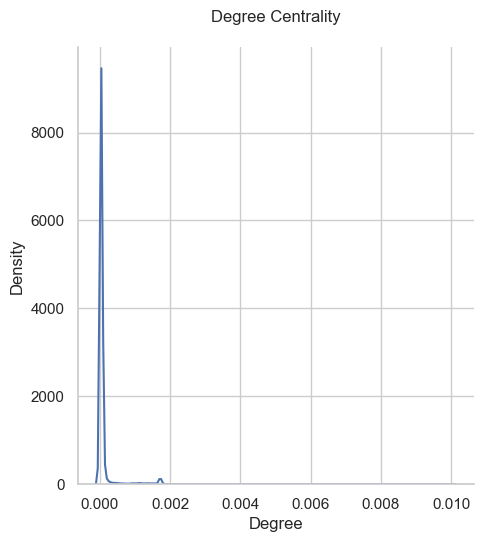

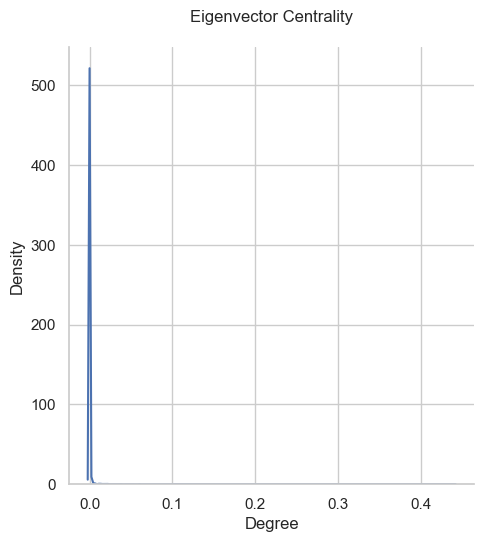

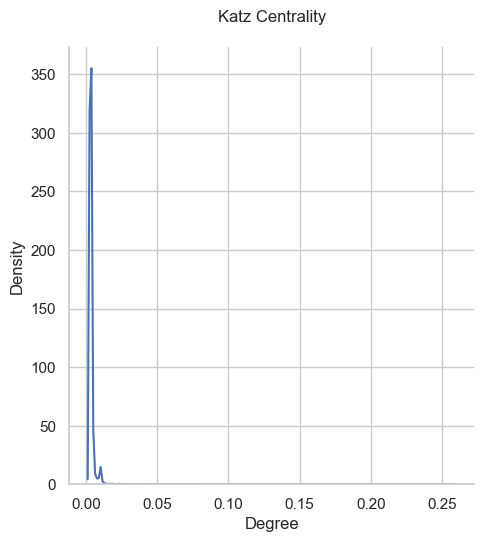

In [47]:
sns.displot(data=list(nx.degree_centrality(ff_graph).values()), kind='kde')
plt.title('Degree Centrality\n')
plt.xlabel('Degree')
plt.show()

sns.displot(data=list(nx.eigenvector_centrality(ff_graph).values()), kind='kde')
plt.title('Eigenvector Centrality\n')

plt.xlabel('Degree')
plt.show()

sns.displot(data=list(nx.katz_centrality(ff_graph).values()), kind='kde')
plt.title('Katz Centrality\n')
plt.xlabel('Degree')
plt.show()

# plt.subplot(1, 3, 1)
# # plt.hist()
# sns.displot(data=list(nx.degree_centrality(ff_graph).values()), kind='kde')
# plt.title('A. Degree Centrality')
# plt.xlabel('Centrality')

# plt.subplot(1, 3, 2)
# # plt.hist(list(nx.eigenvector_centrality(ff_graph).values()))
# sns.displot(data=list(nx.eigenvector_centrality(ff_graph).values()), kind='kde')

# plt.title('B. Eigenvector Centrality')
# plt.xlabel('Centrality')

# plt.subplot(1, 3, 3)
# # plt.hist(list(nx.katz_centrality(ff_graph).values()))
# sns.displot(data=list(nx.katz_centrality(ff_graph).values()), kind='kde')

# plt.title('C. Katz Centrality')
# plt.xlabel('Centrality')

# plt.tight_layout()
# plt.show()

## Big Graph

This graphs consists of two node types:
    1. A user: user in the system with attribute is_ego to determine if they will be used in rec sys.
    2. A repository: a repository that at least 1 user has starred
    
Users: users connect to users like an egonet from above but only using following to keep the graph a little smaller.

Repository: users connect to repositories if they have starred them

In [129]:
# A directed graph
G = nx.DiGraph()

# First, setup a graph of the ego users along with repos they've starred
user_items = pd.read_csv('./data/user-items-ratings-improved.csv')
for row in user_items.itertuples():
    
    uname = row[1]
    rname = row[2]
    rating = row[3]
    # TODO: remove after testing
#     if uname != '0x00evil':
#         break
        
    if uname in G:
        G.nodes[uname]['star_count'] += 1
    else:
        G.add_node(uname, ntype='user', is_ego=True, star_count=1)
    
    if rname not in G:
        G.add_node(rname, ntype='repo')
        
    G.add_edge(uname, rname, weight=rating)
    
# With that graph setup, we now incorporate the egonet data along with more repo data
for ego in egos:
    # TODO: remove after testing
#     if ego == '0x00evil':
    following = egos[ego]['following']
    for f in following:
        uname = f['login']
        if uname not in G:
            G.add_node(uname, ntype='user', is_ego=False, star_count=0)
        G.add_edge(uname, ego)

        for rname in f['starredRepositories']['nodes']:
            rname = rname['nameWithOwner']
            if rname not in G:
                G.add_node(rname, ntype='repo', weight=0)
            G.nodes[uname]['star_count'] += 1
            G.add_edge(uname, rname)

In [130]:
degree_centrality = nx.degree_centrality(G)
eigenvector_centrality = nx.degree_centrality(G)
katz_centrality = nx.katz_centrality(G)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [133]:
# Store eigenvector centrality as node attribute `eigen`
for nid, cent in eigenvector_centrality.items():
    G.nodes[nid]['eigen'] = float(cent)
    
# Do the same for katz
for nid, cent in katz_centrality.items():
    G.nodes[nid]['katz'] = float(cent)

In [135]:
# Compute clustering
print(f'Global clustering coefficient/transitivity = {nx.transitivity(G)}')

# Compute components
print('number of strongly connected components = {}'.format(nx.number_strongly_connected_components(G)))
print('number of weakly connected components = {}'.format(nx.number_weakly_connected_components(G)))

# Compute bridges
print(f'Total number of bridges: {len(list(nx.bridges(G.to_undirected())))}')



Global clustering coefficient/transitivity = 7.513123880407464e-05
number of strongly connected components = 390741
number of weakly connected components = 1
Total number of bridges: 280068


In [207]:
len(G.nodes)
len(G.edges)

888076

In [204]:
nx.triadic_census(G)

{'003': 9942765914181778,
 '012': 346898754346,
 '102': 1171547,
 '021D': 38293343,
 '021U': 15181238,
 '021C': 263314,
 '111D': 89,
 '111U': 562,
 '030T': 5699,
 '030C': 0,
 '201': 0,
 '120D': 12,
 '120U': 16,
 '120C': 0,
 '210': 0,
 '300': 0}

In [99]:
nx.write_graphml(G, './single-user-user-items-following-graph.graphml')

In [ ]:
# pos = nx.spring_layout(G, seed=1) # pos of nodes, seed for reproducability

# # Nodes
# nx.draw_networkx_nodes(G, pos, node_size=100)

# # Edges

# ax = plt.gca()
# ax.margins(0.08)
# plt.axis("off")
# plt.tight_layout()
# plt.show()
nx.draw_networkx(G, 
                 arrows=True, 
                 with_labels=False, 
                 pos=nx.spring_layout(, scale=20))
plt.show()

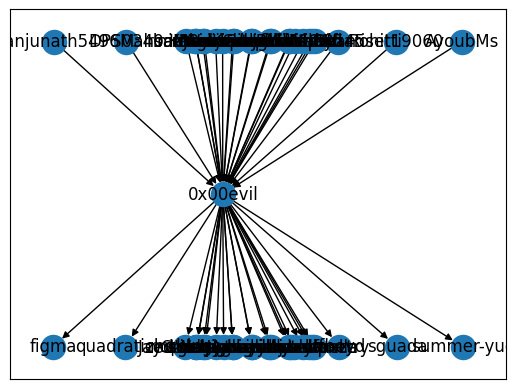

In [25]:
nx.draw_networkx(egonet, 
                 arrows=True, 
                 with_labels=True, 
                 pos=nx.kamada_kawai_layout(egonet, scale=20))

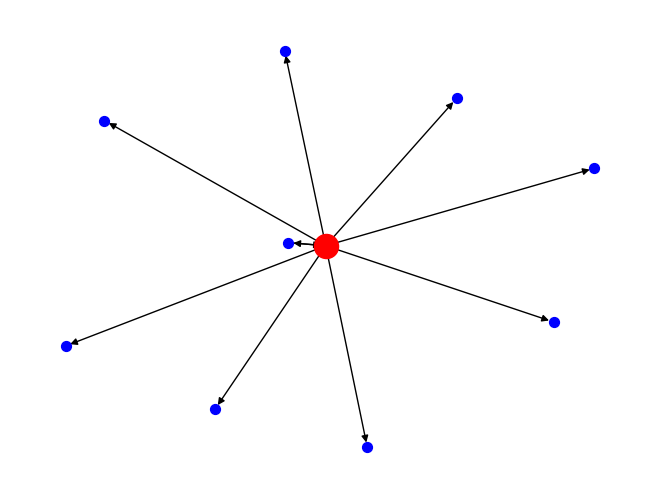

In [208]:
from operator import itemgetter

seed = 123

sample_egonet = ego_graphs['codekip']
node_and_degree = sample_egonet.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]
hub_ego = nx.ego_graph(sample_egonet, largest_hub)

# Draw graph
pos = nx.spring_layout(hub_ego, seed=seed)  # Seed layout for reproducibility
# pos = nx.kamada_kawai_layout(hub_ego, scale=20)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)
plt.show()


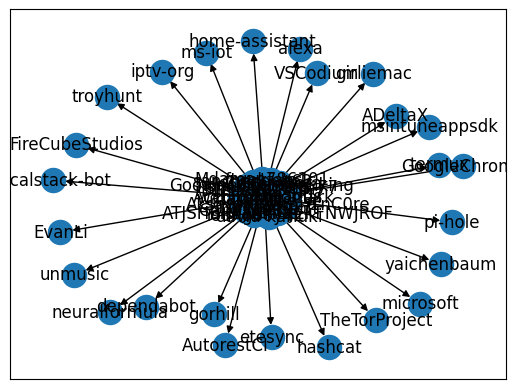

In [211]:
nx.draw_networkx(ego_graphs['Accordingtomark'], 
                 arrows=True, 
                 with_labels=True, 
                 pos=nx.spring_layout(ego_graphs['Accordingtomark']))

 
    

In [166]:
ego_graphs['Accordingtomark']

In [26]:
nx.write_graphml(egonet, './test.graphml')